# Convert timezone
***

**Autor:** Chus Casado Rodríguez<br>
**Date:** 23-05-2025<br>

**Introduction:**<br>

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from datetime import datetime, timedelta
from tqdm.auto import tqdm

from lisfloodreservoirs.utils import DatasetConfig
from lisfloodreservoirs import read_attributes
from lisfloodreservoirs.utils.plots import plot_resops, reservoir_analysis, compare_flows
from lisfloodreservoirs.utils.timeseries import clean_storage, clean_inflow, time_encoding
from lisfloodreservoirs.utils.timezone import *

In [2]:
# from timezonefinder import TimezoneFinder
# import matplotlib.pyplot as plt

## dummy case

In [3]:
# create dummy series the local timezone
Vo = 4 * 1e6
inflow = pd.Series([100, 110, 120, 200, 180, 150, 125, 110, 105, 100], name='inflow')
outflow = pd.Series([95, 100, 100, 120, 140, 150, 140, 120, 110, 100], name='outflow')
ts = pd.concat([inflow, outflow], axis=1)
ts.index = pd.date_range(start=datetime(2020, 3, 26), periods=len(inflow), freq='D')
ts.index.name = 'time'

# remove random values
# ts.loc[dates[3], 'inflow'] = np.nan
# ts.loc[dates[5], 'outflow'] = np.nan
# ts.loc[dates[1], 'storage'] = np.nan

### `.reindex()`

America/Los_Angeles
offset: 7 h


,inflow,outflow,storage,storage_wb1,storage_wb2
time,,,,,
2020-03-26 00:00:00+00:00,100.000000,95.000000,4000000.0,4000000.0,4000000.0
2020-03-27 00:00:00+00:00,107.083333,98.541667,4306000.0,4432000.0,4432000.0
2020-03-28 00:00:00+00:00,117.083333,100.000000,5044000.0,5170000.0,5044000.0
2020-03-29 00:00:00+00:00,176.666667,114.166667,6520000.0,6646000.0,6520000.0
2020-03-30 00:00:00+00:00,185.833333,134.166667,11920000.0,12046000.0,11920000.0
2020-03-31 00:00:00+00:00,158.750000,147.083333,16384000.0,16510000.0,16384000.0
2020-04-01 00:00:00+00:00,132.291667,142.916667,17392000.0,17518000.0,17392000.0
2020-04-02 00:00:00+00:00,114.375000,125.833333,16474000.0,16600000.0,16474000.0
2020-04-03 00:00:00+00:00,106.458333,112.916667,15484000.0,15610000.0,15484000.0


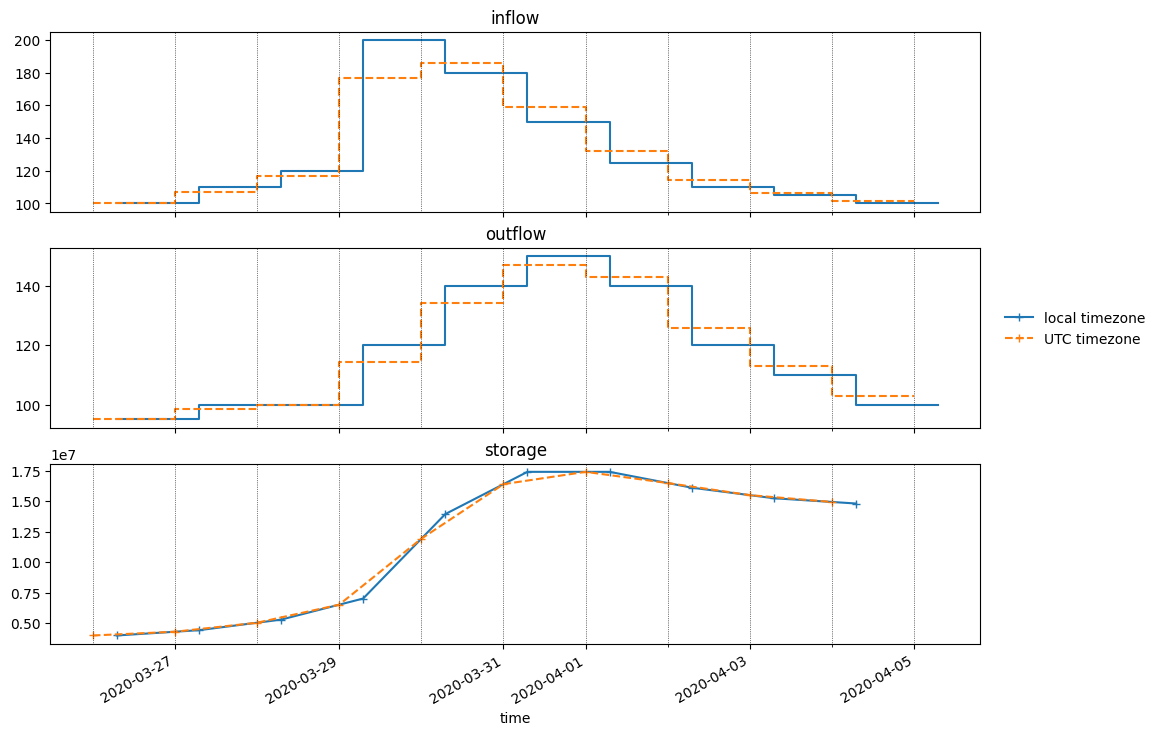

In [4]:
# California
lon = -121
lat = 37

# # Australia
# lon = 150
# lat = -30

# # Madrid
# lon = -3.5
# lat = 40

# # London
# lon = 0
# lat = 51

# convert time series to UTC (with offset)
ts_utc = convert_to_utc(lon, lat, ts)
print(convert_to_utc.local_tz)
print(f'offset: {convert_to_utc.offset} h')

# calculate storage by water balance
ts_utc['storage'] = water_balance_iterative(Vo, ts_utc.inflow, ts_utc.outflow)

# interpolate values to 00 UTC
ts_reindex = reindex_to_00utc(ts_utc)

# compute storage by water balance
ts_reindex['storage_wb1'] = water_balance_iterative(
    ts_reindex.storage.iloc[0], 
    ts_reindex.inflow, 
    ts_reindex.outflow
)
ts_reindex['storage_wb2'] = water_balance_timestep(
    ts_reindex.storage, 
    ts_reindex.inflow, 
    ts_reindex.outflow
)

plot_tz_conversion(ts_utc, ts_reindex)

ts_reindex

### `.resample()`

America/Los_Angeles
offset: 7 h
offset: 7 h
offset: 7 h
offset: 7 h


,inflow,outflow,storage,storage_wb1,storage_wb2
2020-03-26 00:00:00+00:00,100.000000,95.000000,4000000.0,4000000.0,4000000.0
2020-03-27 00:00:00+00:00,107.083333,98.541667,4306000.0,4432000.0,4432000.0
2020-03-28 00:00:00+00:00,117.083333,100.000000,5044000.0,5170000.0,5044000.0
2020-03-29 00:00:00+00:00,176.666667,114.166667,6520000.0,6646000.0,6520000.0
2020-03-30 00:00:00+00:00,185.833333,134.166667,11920000.0,12046000.0,11920000.0
2020-03-31 00:00:00+00:00,158.750000,147.083333,16384000.0,16510000.0,16384000.0
2020-04-01 00:00:00+00:00,132.291667,142.916667,17392000.0,17518000.0,17392000.0
2020-04-02 00:00:00+00:00,114.375000,125.833333,16474000.0,16600000.0,16474000.0
2020-04-03 00:00:00+00:00,106.458333,112.916667,15484000.0,15610000.0,15484000.0
2020-04-04 00:00:00+00:00,104.375000,108.750000,14926000.0,15052000.0,14926000.0


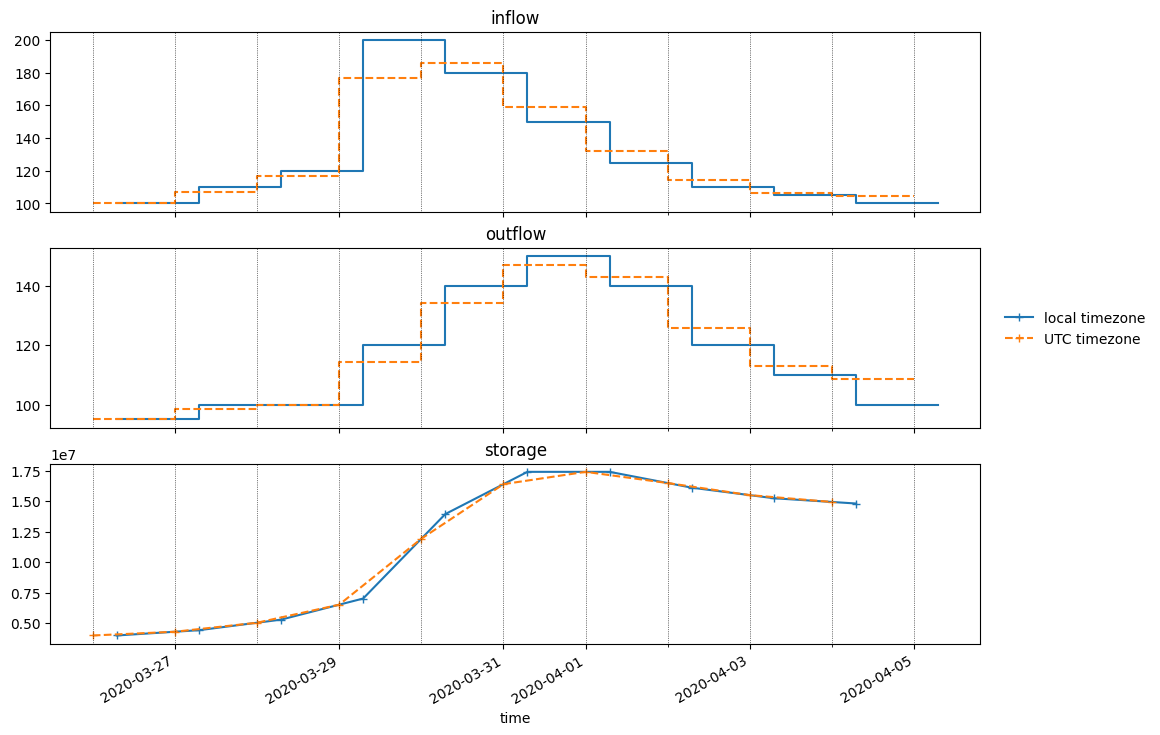

In [5]:
variable_kind = {
    'inflow': 'average',
    'outflow': 'average',
    'storage': 'instant'
}

# convert time series to UTC (with offset)
ts_utc = convert_to_utc(lon, lat, ts)
print(convert_to_utc.local_tz)
print(f'offset: {convert_to_utc.offset} h')

# calculate storage by water balance
ts_utc['storage'] = water_balance_iterative(Vo, ts_utc.inflow, ts_utc.outflow)

# interpolate values to 00 UTC
ts_resample = pd.concat(
    [resample_to_00utc(ts_utc[[var]], kind=kind) for var, kind in variable_kind.items()], 
    axis=1
)
# ts_resample.dropna(axis=0, how='all', inplace=True)

# compute storage by water balance
ts_resample['storage_wb1'] = water_balance_iterative(
    ts_resample.storage.iloc[0], 
    ts_resample.inflow, 
    ts_resample.outflow
)
ts_resample['storage_wb2'] = water_balance_timestep(
    ts_resample.storage, 
    ts_resample.inflow, 
    ts_resample.outflow
)

plot_tz_conversion(ts_utc, ts_resample)

ts_resample

***

## Real data

### Configuration

In [6]:
cfg = DatasetConfig('config_ResOpsUS_v21.yml')

print(f'Time series will be saved in {cfg.PATH_TS}')

Time series will be saved in Z:\nahaUsers\casadje\datasets\reservoirs\ResOpsUS\v2.1\time_series


### Attributes


In [7]:
# import all tables of attributes
attributes = read_attributes(cfg.PATH_ATTRS)
print(f'{attributes.shape[0]} reservoirs in the attribute tables')

677 reservoirs in the attribute tables


### Time series
#### Oberserved: ResOpsUS

In [8]:
path_plots = cfg.PATH_TS / 'plots'
path_plots.mkdir(parents=True, exist_ok=True)
resops_ts = {}
for grand_id in tqdm(attributes.index[:5], desc='Reading observed time series'): # ID refers to GRanD

    # load timeseries
    file = cfg.PATH_OBS_TS / f'ResOpsUS_{grand_id}.csv'
    if file.is_file():
        series = pd.read_csv(file, parse_dates=True, index_col='date')
    else:
        print(f"{file} doesn't exist")

    # remove duplicated index
    series = series[~series.index.duplicated(keep='first')]
    # trim to GloFAS long run period
    start, end = cfg.START, cfg.END
    series = series.loc[start:end,:]
    if series.empty:
        print(f'Reservoir {grand_id} has no observations in the time period from {start} to {end}')
        continue
    # ensure there aren't gaps in the index
    dates = pd.date_range(series.first_valid_index(), series.last_valid_index(), freq='D')
    series = series.reindex(dates)
    series.index.name = 'date'

    # remove negative values
    series[series < 0] = np.nan
    # clean storage time series
    series.storage = clean_storage(series.storage, w=7, error_thr=0.1)
    # clean inflow time series
    series.inflow = clean_inflow(
        series.inflow, 
        storage=series.storage if attributes.loc[grand_id, 'STORAGE'] == 1 else None, 
        outlfow=series.outflow if attributes.loc[grand_id, 'OUTFLOW'] == 1 else None, 
        grad_thr=1e4, 
        balance_thr=5, 
        int_method='linear'
    )
    # save in dictionary
    resops_ts[grand_id] = series

    # plot observed time series
    plot_resops(
        series.storage,
        series.elevation,
        series.inflow,
        series.outflow,
        attributes.loc[grand_id, ['CAP_MCM', 'CAP_GLWD']].values,
        title=grand_id,
        save=path_plots / f'{grand_id:04}_lineplot.jpg'
        )

print(f'{len(resops_ts)} reservoirs in ResOpsUS time series')

Reading observed time series:   0%|          | 0/5 [00:00<?, ?it/s]

5 reservoirs in ResOpsUS time series


### Conversion

In [10]:
for grand_id, ts in resops_ts.items():
    break

In [12]:
   lon, lat = attributes.loc[grand_id, ['LON', 'LAT']]

In [15]:
def plot_tz_conversion(
    original: pd.DataFrame,
    shifted: pd.DataFrame,
    plot_dates: bool = True,
):
    """
    Plot and compare original and timezone-shifted time series data 
    for 'inflow', 'outflow', and 'storage' variables.

    This function visualizes the effects of timezone conversion by 
    plotting two DataFrames (one in local time and one in UTC) on 
    separate subplots. Step plots are used for 'inflow' and 'outflow',
    while line plots with markers are used for 'storage'. Vertical lines
    mark day boundaries in the UTC-shifted data.

    Parameters
    ----------
    original : pd.DataFrame
        Time series data in local timezone with columns: 'inflow', 'outflow', 'storage'.
    
    shifted : pd.DataFrame
        Time series data converted to UTC, with the same structure as `original`.
    plot_dates: boolean
        Whether to plot vertical lines to show the dates in UTC.

    Returns
    -------
    None
        Displays a matplotlib figure with three subplots and a shared legend.
    """
    
    original = original.copy()
    original.loc[original.index[-1] + pd.Timedelta(days=1)] = np.nan
    shifted = shifted.copy()
    shifted.loc[shifted.index[-1] + pd.Timedelta(days=1)] = np.nan
    
    fig, axes = plt.subplots(figsize=(12, 9), nrows=3, sharex=True)
    for ax, variable in zip(axes, ['inflow', 'outflow', 'storage']):
        drawstyle = 'steps-post' if variable in ['inflow', 'outflow'] else 'default'
        marker = None if variable in ['inflow', 'outflow'] else '+'
        # original values 
        original[variable].plot(
            ax=ax, 
            label='local timezone', 
            drawstyle=drawstyle,
            marker=marker
        )
        # shifted values
        shifted[variable].plot(
            ax=ax, 
            label='UTC timezone', 
            drawstyle=drawstyle,
            linestyle='--',
            marker=marker
        )
        if plot_dates:
            for date in np.unique(shifted.index.date):
                ax.axvline(date, c='k', lw=.5, ls=':')
        ax.set_title(variable)
    
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, frameon=False, loc=6, bbox_to_anchor=[.91, .4, .1, .3]);

In [ ]:
    # convert time series to UTC (with offset)
    ts_utc = convert_to_utc(lon, lat, ts)
    print(convert_to_utc.local_tz)
    print(f'offset: {convert_to_utc.offset} h')
    
    # interpolate values to 00 UTC
    ts_reindex = reindex_to_00utc(ts_utc)
    
    # # compute storage by water balance
    # ts_reindex['storage_wb1'] = water_balance_iterative(
    #     ts_reindex.storage.iloc[0], 
    #     ts_reindex.inflow, 
    #     ts_reindex.outflow
    # )
    # ts_reindex['storage_wb2'] = water_balance_timestep(
    #     ts_reindex.storage, 
    #     ts_reindex.inflow, 
    #     ts_reindex.outflow
    # )
    
    plot_tz_conversion(ts_utc, ts_reindex)
    
    ts_reindex

America/Los_Angeles
offset: 7 h


***